# BTCUSDT dollar bars 数据分析

本笔记本分析以下文件：
- `data\preprocess_data\dollar_bars\BTCUSDT\BTCUSDT_2025-01-01_2025-12-31_dollar_bars_4m.csv`

目标：
1. 统计每日生成的 bar 数量并绘制分布
2. 统计 dollar bar 生成频率（相邻 bar 时间间隔）分布，并分析极端同时生成情况
3. 分析 dollar bar 成交额分布

说明：所有分布图均使用原始尺度（不取对数）。

## 1. 加载数据与基础清洗

- 读取 CSV
- 解析时间列为 `datetime`
- 按时间排序
- 处理缺失值与重复行
- 展示基础统计

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set_theme(style="whitegrid")

# 解析项目根目录（包含 pyproject.toml）
cwd = Path.cwd().resolve()
root = next((p for p in [cwd, *cwd.parents] if (p / "pyproject.toml").exists()), cwd)

file_path = root / "data" / "preprocess_data" / "dollar_bars" / "BTCUSDT" / "BTCUSDT_2025-01-01_2025-12-31_dollar_bars_4m.csv"

df = pd.read_csv(file_path)
print("rows, cols:", df.shape)
print(df.head(3))
print(df.columns)

# 尝试自动识别时间列
lower_cols = {c.lower(): c for c in df.columns}
possible_time_cols = [
    "timestamp", "time", "datetime", "date", "open_time", "opentime", "bar_time"
 ]

time_col = None
for key in possible_time_cols:
    if key in lower_cols:
        time_col = lower_cols[key]
        break

if time_col is None:
    raise ValueError("未找到时间列，请检查 CSV 列名。")

# 解析时间列（timestamp 同时包含 ms 和 us）
if np.issubdtype(df[time_col].dtype, np.number):
    ts = pd.to_numeric(df[time_col], errors="coerce")
    # 按数量级区分：us (~1e15) 与 ms (~1e12)
    us_mask = ts >= 1e14
    df["dt"] = pd.NaT
    df.loc[us_mask, "dt"] = pd.to_datetime(ts[us_mask], unit="us", errors="coerce")
    df.loc[~us_mask, "dt"] = pd.to_datetime(ts[~us_mask], unit="ms", errors="coerce")
else:
    df["dt"] = pd.to_datetime(df[time_col], errors="coerce")

print(df[["dt"]].describe())

rows, cols: (82145, 9)
          timestamp      open      high       low     close    volume  \
0  1735689600010866  93576.00  93702.15  93537.50  93677.98  48.22810   
1  1735689943095820  93677.98  93678.02  93600.00  93612.00  48.23934   
2  1735690098318322  93612.00  93623.38  93536.52  93544.58  48.28969   

   dollar_volume  num_trades        close_time  
0   4.516081e+06        3606  1735689942737373  
1   4.516821e+06        1303  1735690098274250  
2   4.519979e+06        1175  1735690260293220  
Index(['timestamp', 'open', 'high', 'low', 'close', 'volume', 'dollar_volume',
       'num_trades', 'close_time'],
      dtype='object')
                                  dt
count                          82145
mean   2025-07-01 10:03:48.208542208
min       2025-01-01 00:00:00.010866
25%       2025-04-01 03:17:52.058688
50%    2025-07-02 02:07:27.967532032
75%    2025-10-01 09:07:53.491052032
max       2025-12-31 23:38:18.734186


## 2. 按日统计生成的 bar 数量与频率分布

- 统计每天生成的 bar 数量
- 绘制频率分布图
- 输出分布特征指标（均值、中位数、分位数、偏态）

count    365.000000
mean     225.054795
std       87.378061
min       63.000000
25%      166.000000
50%      214.000000
75%      275.000000
max      549.000000
Name: bar_count, dtype: float64
skew: 0.6935275959213651
quantiles:
 0.05     92.2
0.25    166.0
0.50    214.0
0.75    275.0
0.95    386.4
Name: bar_count, dtype: float64
days in range [144, 288]: 233/365 (63.84%)


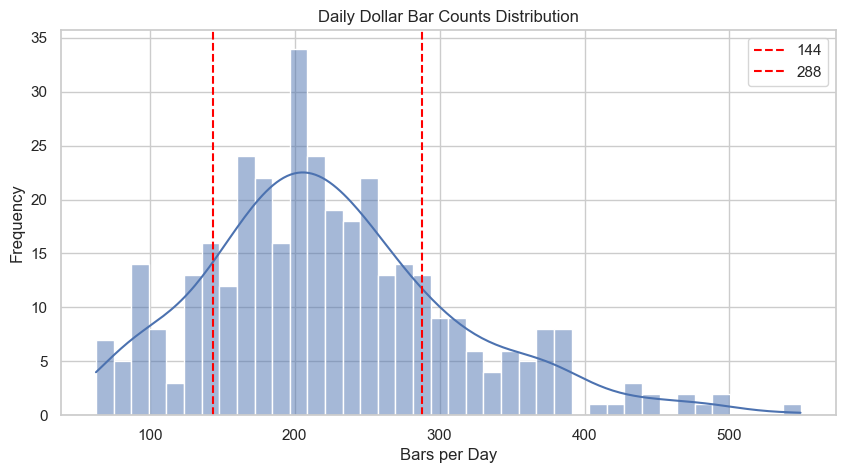

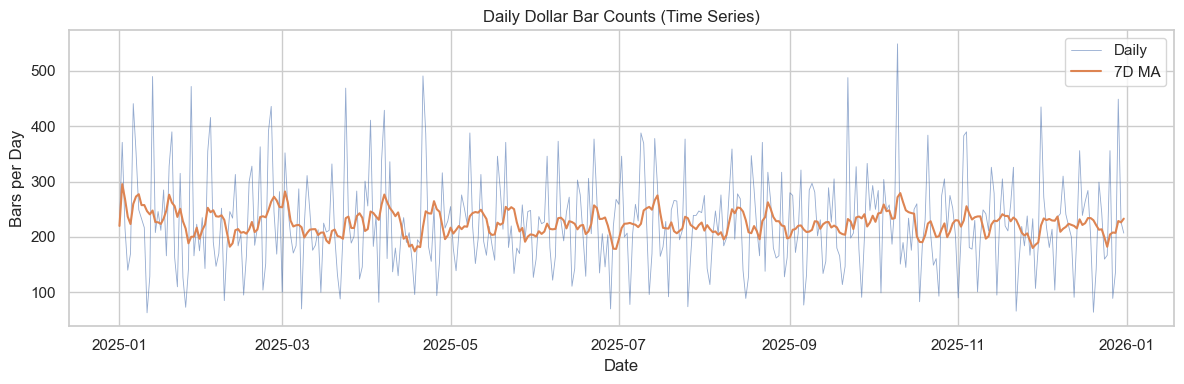

In [2]:
# 每日 bar 数量

df["date"] = df["dt"].dt.date

daily_counts = df.groupby("date").size().rename("bar_count")

print(daily_counts.describe())
print("skew:", daily_counts.skew())
print("quantiles:\n", daily_counts.quantile([0.05, 0.25, 0.5, 0.75, 0.95]))

# 区间统计
low, high = 144, 288
in_range = daily_counts.between(low, high)
range_count = int(in_range.sum())
total_days = int(len(daily_counts))
print(f"days in range [{low}, {high}]: {range_count}/{total_days} ({range_count/total_days:.2%})")

plt.figure(figsize=(10, 5))
sns.histplot(daily_counts, bins=40, kde=True)
plt.axvline(low, color="red", linestyle="--", label=str(low))
plt.axvline(high, color="red", linestyle="--", label=str(high))
plt.title("Daily Dollar Bar Counts Distribution")
plt.xlabel("Bars per Day")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# 时序图（线图 + 7日滚动均值）
daily_ts = daily_counts.sort_index()
rolling_7d = daily_ts.rolling(window=7, min_periods=1).mean()
plt.figure(figsize=(12, 4))
plt.plot(daily_ts.index, daily_ts.values, color="#4C72B0", linewidth=0.6, alpha=0.6, label="Daily")
plt.plot(rolling_7d.index, rolling_7d.values, color="#DD8452", linewidth=1.5, label="7D MA")
plt.title("Daily Dollar Bar Counts (Time Series)")
plt.xlabel("Date")
plt.ylabel("Bars per Day")
plt.legend()
plt.tight_layout()
plt.show()

**分布解读要点（运行后基于输出补充）：**
- 观察均值与中位数的差异判断偏态方向。
- 使用 5%/95% 分位数衡量波动区间。
- 偏态系数若显著大于 0，说明存在高频“多 bar 日”。

## 3. dollar bar 生成频率分布与极端同时生成分析

- 计算相邻 bar 的时间间隔
- 绘制生成频率分布图
- 统计相邻时间戳相同的同时生成情况（数量与连续长度）

count    82144.000000
mean       383.895339
std        357.237611
min          0.000000
25%        119.891119
50%        279.934653
75%        542.471503
max       3519.961801
Name: dt, dtype: float64
skew: 1.6965698318964102
quantiles:
 0.05      21.802968
0.25     119.891119
0.50     279.934653
0.75     542.471503
0.95    1095.333241
Name: dt, dtype: float64


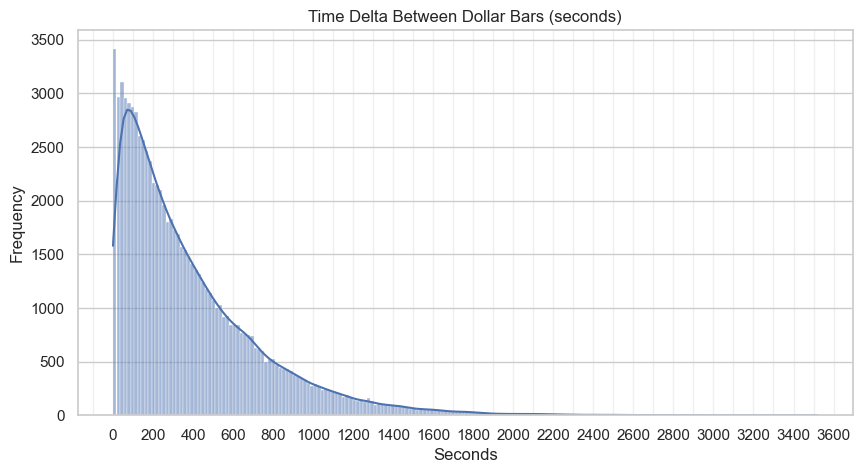

zero intervals count: 41
simultaneous groups: 40
simul group length stats:
 count    40.000000
mean      2.025000
std       0.158114
min       2.000000
25%       2.000000
50%       2.000000
75%       2.000000
max       3.000000
Name: dt, dtype: float64
top 10 simultaneous lengths:
 dt
2025-04-19 05:25:50.128794    3
2025-01-06 04:55:03.857107    2
2025-01-06 06:58:24.384924    2
2025-04-19 04:52:44.524036    2
2025-04-19 07:27:11.140807    2
2025-04-20 07:11:16.791429    2
2025-04-20 12:04:43.841005    2
2025-04-21 01:13:42.755207    2
2025-04-21 16:18:23.211599    2
2025-04-27 22:28:37.385638    2
Name: dt, dtype: int64


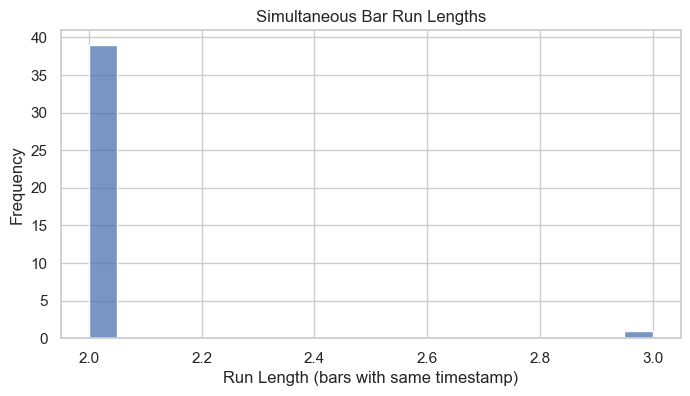

C:\Users\Ithai\AppData\Local\Temp\ipykernel_13332\3640886746.py:55: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  delta_hourly = delta_ts.resample("1H").median()


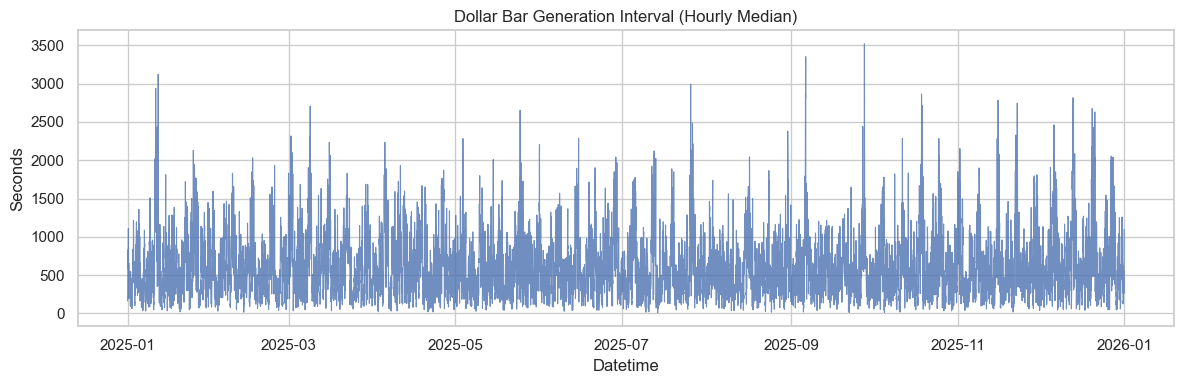

In [3]:
# 相邻 bar 时间间隔（秒）

import matplotlib.ticker as mticker

delta_seconds = df["dt"].diff().dt.total_seconds().dropna()

print(delta_seconds.describe())
print("skew:", delta_seconds.skew())
print("quantiles:\n", delta_seconds.quantile([0.05, 0.25, 0.5, 0.75, 0.95]))

plt.figure(figsize=(10, 5))
sns.histplot(delta_seconds, bins=200, kde=True)
plt.title("Time Delta Between Dollar Bars (seconds)")
plt.xlabel("Seconds")
plt.ylabel("Frequency")
ax = plt.gca()
ax.xaxis.set_major_locator(mticker.MaxNLocator(nbins=25))
ax.xaxis.set_minor_locator(mticker.AutoMinorLocator(2))
ax.grid(True, which="both", axis="x", alpha=0.3)
plt.show()

# 极端情况：相同时间戳的同时生成
same_ts = df["dt"].diff().dt.total_seconds().fillna(1) == 0
zero_intervals = same_ts.sum()

# 计算同一时间戳连续出现的长度
run_lengths = (
    df["dt"]
    .ne(df["dt"].shift())
    .cumsum()
    .groupby(df["dt"])
    .size()
 )

# 仅保留长度 >= 2 的“同时生成”组
simul_groups = run_lengths[run_lengths >= 2]

print("zero intervals count:", int(zero_intervals))
print("simultaneous groups:", int(simul_groups.size))
print("simul group length stats:\n", simul_groups.describe())
print("top 10 simultaneous lengths:\n", simul_groups.sort_values(ascending=False).head(10))

plt.figure(figsize=(8, 4))
if len(simul_groups) > 0:
    sns.histplot(simul_groups, bins=20, kde=False)
    plt.title("Simultaneous Bar Run Lengths")
    plt.xlabel("Run Length (bars with same timestamp)")
    plt.ylabel("Frequency")
    plt.show()
else:
    print("No simultaneous bars detected.")

# 时序图（按小时中位数，避免过密）
delta_ts = pd.Series(delta_seconds.values, index=df["dt"].iloc[1:])
delta_hourly = delta_ts.resample("1H").median()
plt.figure(figsize=(12, 4))
plt.plot(delta_hourly.index, delta_hourly.values, color="#4C72B0", linewidth=0.8, alpha=0.8)
plt.title("Dollar Bar Generation Interval (Hourly Median)")
plt.xlabel("Datetime")
plt.ylabel("Seconds")
plt.tight_layout()
plt.show()

**分布解读要点（运行后基于输出补充）：**
- 间隔分布是否右偏（大量小间隔 + 少量极大间隔）。
- `zero intervals count` 代表相邻两根 bar 同时生成的次数。
- `simul group length stats` 与直方图反映“同时生成”的持续长度分布。

## 4. dollar bar 成交额分布分析

- 选择成交额字段（若不存在则用 `price * volume` 计算）
- 绘制成交额分布图
- 描述分布特征与极端值情况

turnover column: dollar_volume
count    8.214500e+04
mean     9.340817e+06
std      4.369986e+06
min      2.480013e+06
25%      6.413358e+06
50%      8.288864e+06
75%      1.114464e+07
max      3.354876e+07
Name: dollar_volume, dtype: float64
skew: 1.519905159227431
quantiles:
 0.05    4.298976e+06
0.25    6.413358e+06
0.50    8.288864e+06
0.75    1.114464e+07
0.95    1.840204e+07
Name: dollar_volume, dtype: float64


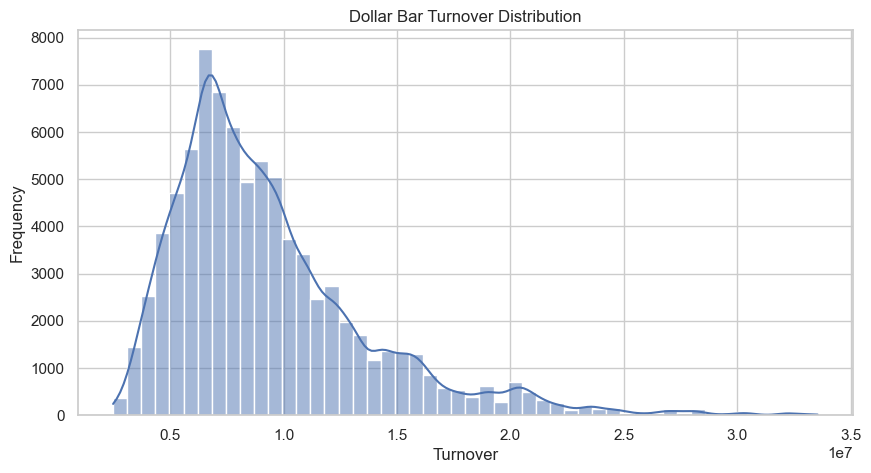

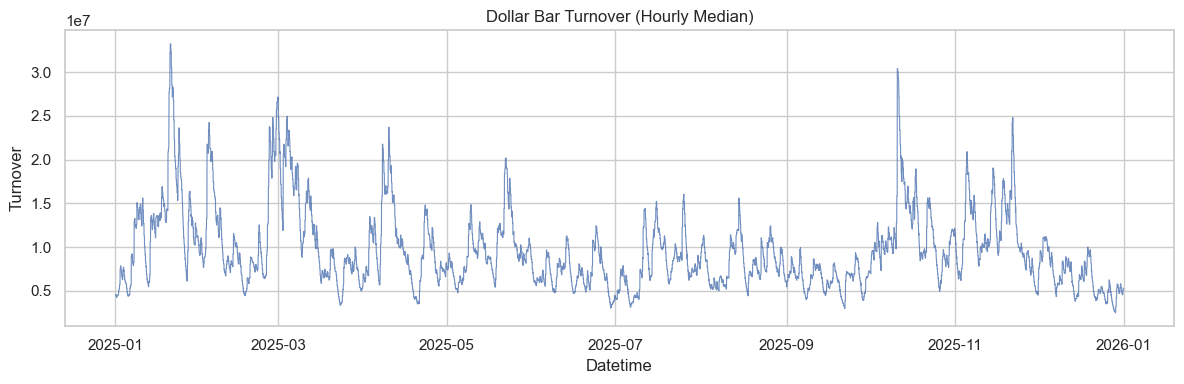

In [5]:
# 选择成交额字段

lower_cols = {c.lower(): c for c in df.columns}

candidate_turnover = [
    "dollar", "dollar_volume", "turnover", "quote_volume", "quote_qty",
    "quote_asset_volume", "amount", "quote_amount"
 ]

turnover_col = None
for key in candidate_turnover:
    if key in lower_cols:
        turnover_col = lower_cols[key]
        break

if turnover_col is None:
    # 退化：用价格 * 成交量
    candidate_price = ["close", "price", "vwap", "avg_price", "avgprice"]
    candidate_volume = ["volume", "qty", "base_volume", "base_qty"]

    price_col = None
    volume_col = None

    for key in candidate_price:
        if key in lower_cols:
            price_col = lower_cols[key]
            break

    for key in candidate_volume:
        if key in lower_cols:
            volume_col = lower_cols[key]
            break

    if price_col is None or volume_col is None:
        raise ValueError("未找到可用于计算成交额的价格或成交量列。")

    df["turnover"] = df[price_col] * df[volume_col]
    turnover_col = "turnover"

print("turnover column:", turnover_col)

turnover_series = df[turnover_col].replace([np.inf, -np.inf], np.nan)
turnover = turnover_series.dropna()

print(turnover.describe())
print("skew:", turnover.skew())
print("quantiles:\n", turnover.quantile([0.05, 0.25, 0.5, 0.75, 0.95]))

plt.figure(figsize=(10, 5))
sns.histplot(turnover, bins=50, kde=True)
plt.title("Dollar Bar Turnover Distribution")
plt.xlabel("Turnover")
plt.ylabel("Frequency")
plt.show()

# 时序图（按小时中位数，避免过密）
turnover_ts = turnover_series.copy()
turnover_ts.index = df["dt"]
turnover_hourly = turnover_ts.resample("1h").median()
plt.figure(figsize=(12, 4))
plt.plot(turnover_hourly.index, turnover_hourly.values, color="#4C72B0", linewidth=0.8, alpha=0.8)
plt.title("Dollar Bar Turnover (Hourly Median)")
plt.xlabel("Datetime")
plt.ylabel("Turnover")
plt.tight_layout()
plt.show()

**分布解读要点（运行后基于输出补充）：**
- 观察分布是否存在长尾与极端高成交额 bar。
- 结合分位数（如 95% 分位）衡量异常值范围。